In [1]:
from packageDsrpMLE2.pre_proc import PreProcessor
from packageDsrpMLE2.config import PARQUET_PATH, FEAST_PROJ_DIR
from feast import FeatureStore
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from prophet import Prophet
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.model_selection import train_test_split

import mlflow

import dagshub

2025-08-24 18:40:14.500 | INFO     | packageDsrpMLE2.config:<module>:7 - La ruta del proyecto es: /home/joe/Documents/DsrpTrabajoFinalMLE2/dsrptrabajofinalmle2
2025-08-24 18:40:14.501 | INFO     | packageDsrpMLE2.config:<module>:32 - Variable DATA_DIR = /home/joe/Documents/DsrpTrabajoFinalMLE2/dsrptrabajofinalmle2/data
2025-08-24 18:40:14.502 | INFO     | packageDsrpMLE2.config:<module>:32 - Variable RAW_DIR = /home/joe/Documents/DsrpTrabajoFinalMLE2/dsrptrabajofinalmle2/data/raw
2025-08-24 18:40:14.503 | INFO     | packageDsrpMLE2.config:<module>:32 - Variable PROCESSED_DIR = /home/joe/Documents/DsrpTrabajoFinalMLE2/dsrptrabajofinalmle2/data/processed
2025-08-24 18:40:14.504 | INFO     | packageDsrpMLE2.config:<module>:32 - Variable CSV_FILE = /home/joe/Documents/DsrpTrabajoFinalMLE2/dsrptrabajofinalmle2/data/raw/PJME_hourly.csv
2025-08-24 18:40:14.505 | INFO     | packageDsrpMLE2.config:<module>:32 - Variable MODELS_DIR = /home/joe/Documents/DsrpTrabajoFinalMLE2/dsrptrabajofinalmle2/

# PREPROCESAMIENTO DEL DATASET

In [2]:
data = PreProcessor()
data.run()

2025-08-24 18:40:22.914 | INFO     | packageDsrpMLE2.pre_proc:run:33 - Inicializando Pre-Procesamiento de raw data
2025-08-24 18:40:22.917 | INFO     | packageDsrpMLE2.pre_proc:run:34 - Leendo dataset /home/joe/Documents/DsrpTrabajoFinalMLE2/dsrptrabajofinalmle2/data/raw/PJME_hourly.csv 
2025-08-24 18:40:23.113 | INFO     | packageDsrpMLE2.pre_proc:run:36 - Ordenando dataset por la columna tiempo
2025-08-24 18:40:23.126 | INFO     | packageDsrpMLE2.pre_proc:run:38 - Reemplazando valores duplicados por su media
2025-08-24 18:40:23.178 | INFO     | packageDsrpMLE2.pre_proc:run:40 - Interpolando valores faltantes
2025-08-24 18:40:23.212 | INFO     | packageDsrpMLE2.pre_proc:run:43 - Preprocesamiento finalizado...
2025-08-24 18:40:23.214 | INFO     | packageDsrpMLE2.pre_proc:run:46 - Agregando columna ernergy_id al dateset / adecuando para feast
2025-08-24 18:40:24.155 | INFO     | packageDsrpMLE2.pre_proc:run:56 - parquet final guardado en /home/joe/Documents/DsrpTrabajoFinalMLE2/dsrptrab

# Tratado de dataset con FeatureStore Feast

In [3]:
fs = FeatureStore(repo_path=str(FEAST_PROJ_DIR))
entities = pd.read_parquet(PARQUET_PATH, columns=["energy_id", "Datetime"])
features = fs.get_feature_service("dsrp_feature_service")

hist = fs.get_historical_features(
    entity_df=entities,
    features=features,
).to_df()

hist["ds"] = pd.to_datetime(hist["ds"], utc=True).dt.tz_localize(None)

/home/joe/Documents/DsrpTrabajoFinalMLE2/dsrptrabajofinalmle2/.venv/lib/python3.10/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "vector_enabled" in "SqliteOnlineStoreConfig" shadows an attribute in parent "VectorStoreConfig"
  warnings.warn(
/home/joe/Documents/DsrpTrabajoFinalMLE2/dsrptrabajofinalmle2/.venv/lib/python3.10/site-packages/feast/repo_config.py:268: DeprecationWarning: The serialization version 2 and below will be deprecated in the next release. Specifying `entity_key_serialization_version` to 3 is recommended.
  warnings.warn(


Using Datetime as the event timestamp. To specify a column explicitly, please name it event_timestamp.


# Visualizacion de todo el dataset

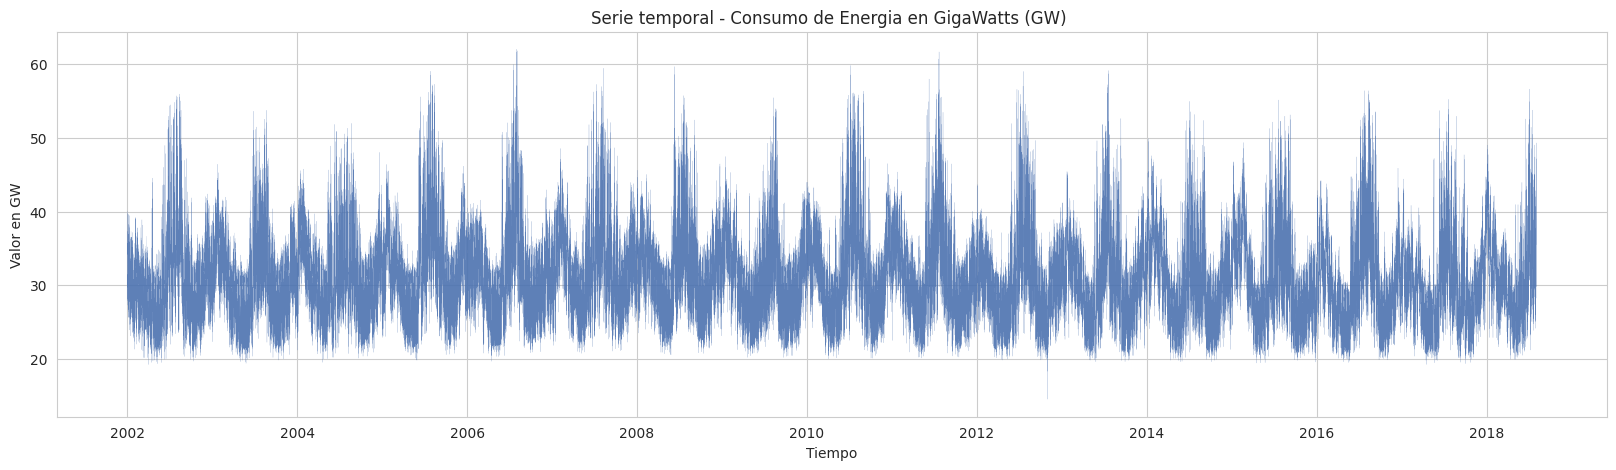

In [4]:
sns.set_style("whitegrid")
sns.set_palette("deep") 
plt.figure(figsize=(20, 5))

sns.lineplot(x='ds', y='y', data=hist, linewidth=0.1, alpha=0.90)

plt.title("Serie temporal - Consumo de Energia en GigaWatts (GW) ")
plt.xlabel("Tiempo")
plt.ylabel("Valor en GW")
plt.show()

# Separando informacion en train y test

In [5]:
train_df = hist[:int(len(hist)*0.8)]
test_df = hist[int(len(hist)*0.8):]

# Login en dagshub

In [6]:
dagshub.init(repo_owner='joseadolfo1',
             repo_name='dsrptrabajofinalmle2',
             mlflow=True)

Accessing as joseadolfo1

Initialized MLflow to track repo "joseadolfo1/dsrptrabajofinalmle2"

Repository joseadolfo1/dsrptrabajofinalmle2 initialized!

In [7]:
mlflow.set_tracking_uri("https://dagshub.com/joseadolfo1/dsrptrabajofinalmle2.mlflow")
name = "DSRP - Trabajo Final del Modulo MLE2"
ex = mlflow.get_experiment_by_name(name)

if ex is None:
    ex_id = mlflow.create_experiment(name)
    print(f"Experimento creado con ID: {ex_id}")
else:
    ex_id = ex.experiment_id
    print(f"Experimento ya existe. Usando ID: {ex_id}")

mlflow.set_experiment(name)

Experimento ya existe. Usando ID: 0


<Experiment: artifact_location='mlflow-artifacts:/883b94a38b0545e2a993fd17d8d6ebc9', creation_time=1755968527946, experiment_id='0', last_update_time=1755968527946, lifecycle_stage='active', name='DSRP - Trabajo Final del Modulo MLE2', tags={}>

# Prophet - multiplicative

2025/08/24 18:40:31 WARNING mlflow.utils.autologging_utils: MLflow sklearn autologging is known to be compatible with 0.24.1 <= scikit-learn <= 1.6.1, but the installed version is 1.7.1. If you encounter errors during autologging, try upgrading / downgrading scikit-learn to a compatible version, or try upgrading MLflow.
2025/08/24 18:40:32 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/08/24 18:40:32 WARNING mlflow.utils.autologging_utils: MLflow statsmodels autologging is known to be compatible with 0.12.2 <= statsmodels <= 0.14.4, but the installed version is 0.14.5. If you encounter errors during autologging, try upgrading / downgrading statsmodels to a compatible version, or try upgrading MLflow.
2025/08/24 18:40:32 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2025/08/24 18:40:32 WARNING mlflow.utils.autologging_utils: MLflow xgboost autologging is known to be compatible with 1.4.2 <= xgboost <= 3.0.0, but the insta

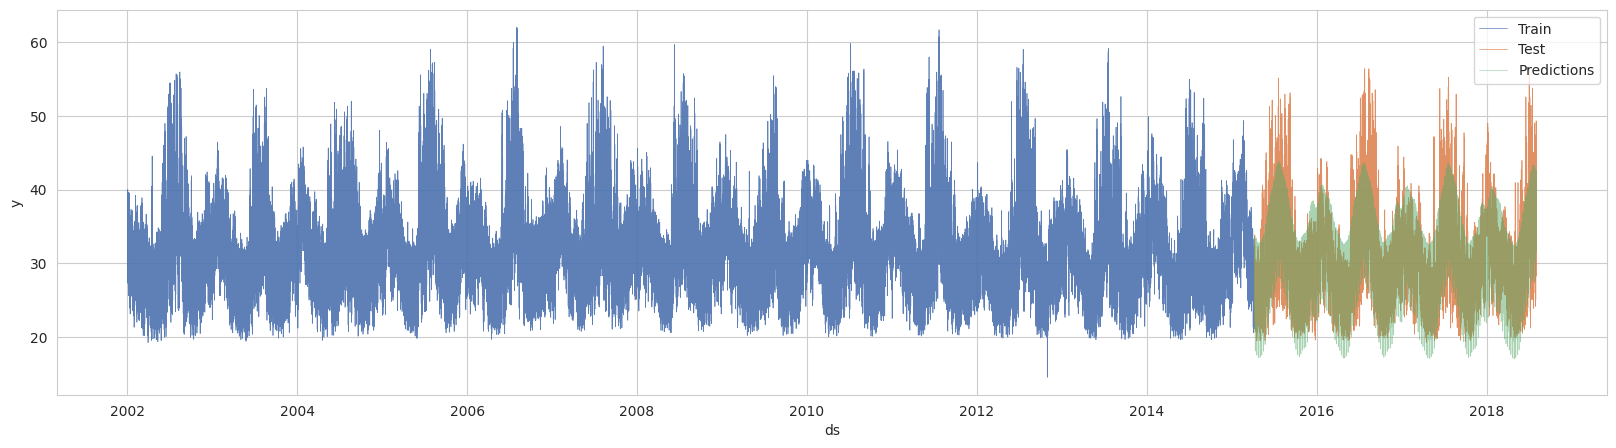

🏃 View run Prophet - multiplicative at: https://dagshub.com/joseadolfo1/dsrptrabajofinalmle2.mlflow/#/experiments/0/runs/25d101b675fa482b8cd3e5d55da7a159
🧪 View experiment at: https://dagshub.com/joseadolfo1/dsrptrabajofinalmle2.mlflow/#/experiments/0


/home/joe/Documents/DsrpTrabajoFinalMLE2/dsrptrabajofinalmle2/.venv/lib/python3.10/site-packages/mlflow/store/tracking/rest_store.py:182: DeprecationWarning: label() is deprecated. Use is_required() or is_repeated() instead.
  req_body = message_to_json(


In [8]:
mlflow.autolog()
with mlflow.start_run(run_name="Prophet - multiplicative") as run:
    model = Prophet(
            yearly_seasonality=True,
            weekly_seasonality=True,
            daily_seasonality=True,
            seasonality_mode="multiplicative"
        )    

    train = train_df[["ds","y"]]
    test = test_df[["ds","y"]]

    model.fit(train)
    predictions = model.predict(test)
    y_pred = predictions['yhat'].values
        
    mae = mean_absolute_error(test['y'], y_pred)
    mape = mean_absolute_percentage_error(test['y'], y_pred)
    mse = mean_squared_error(test['y'], y_pred)
    rmse = np.sqrt(mse)

    mlflow.log_metric("MAE", mae)
    mlflow.log_metric("MAPE", mape)
    mlflow.log_metric("MSE", mse)
    mlflow.log_metric("RMSE", rmse)  

    sns.set_style("whitegrid")
    sns.set_palette("deep") 
    plt.figure(figsize=(20, 5))
    
    sns.lineplot(x='ds', y='y', data=train, label='Train', linewidth=0.5, alpha=0.90)
    sns.lineplot(x='ds', y='y', data=test, label='Test', linewidth=0.5, alpha=0.90)
    sns.lineplot(x=test['ds'], y=y_pred, label='Predictions', linewidth=0.5, alpha=0.50)
    mlflow.log_figure(plt.gcf(), "Prophet_multiplicative.png")
    plt.show()

# Prophet - additive

2025/08/24 18:42:27 WARNING mlflow.utils.autologging_utils: MLflow sklearn autologging is known to be compatible with 0.24.1 <= scikit-learn <= 1.6.1, but the installed version is 1.7.1. If you encounter errors during autologging, try upgrading / downgrading scikit-learn to a compatible version, or try upgrading MLflow.
2025/08/24 18:42:27 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/08/24 18:42:27 WARNING mlflow.utils.autologging_utils: MLflow statsmodels autologging is known to be compatible with 0.12.2 <= statsmodels <= 0.14.4, but the installed version is 0.14.5. If you encounter errors during autologging, try upgrading / downgrading statsmodels to a compatible version, or try upgrading MLflow.
2025/08/24 18:42:27 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2025/08/24 18:42:27 WARNING mlflow.utils.autologging_utils: MLflow xgboost autologging is known to be compatible with 1.4.2 <= xgboost <= 3.0.0, but the insta

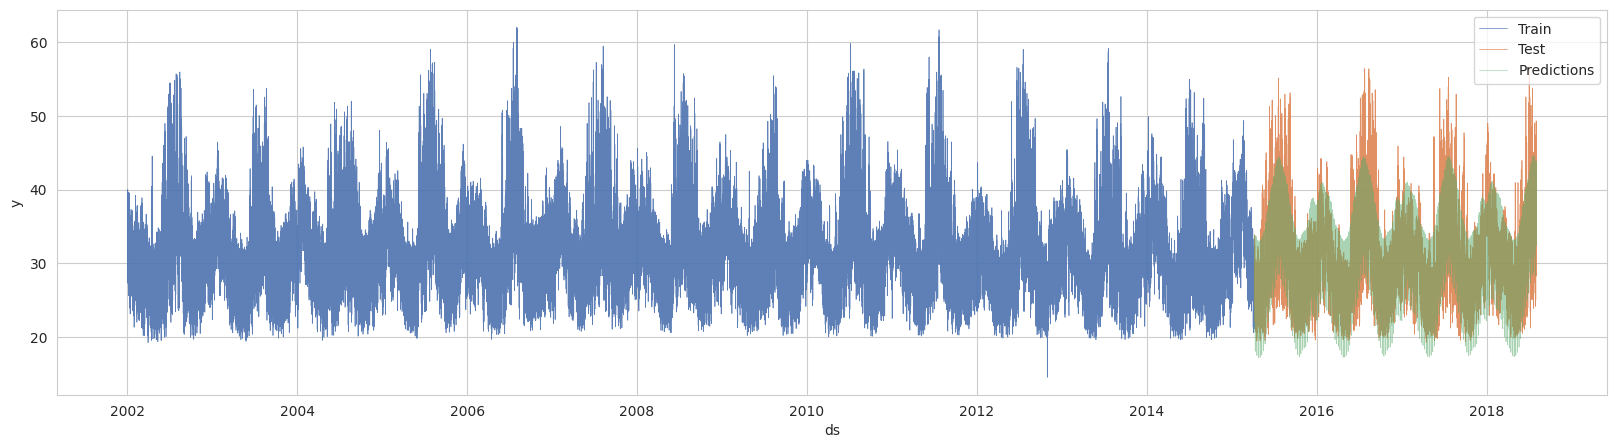

🏃 View run Prophet - additive at: https://dagshub.com/joseadolfo1/dsrptrabajofinalmle2.mlflow/#/experiments/0/runs/69589a1af7c648aa941469bf0368f945
🧪 View experiment at: https://dagshub.com/joseadolfo1/dsrptrabajofinalmle2.mlflow/#/experiments/0


/home/joe/Documents/DsrpTrabajoFinalMLE2/dsrptrabajofinalmle2/.venv/lib/python3.10/site-packages/mlflow/store/tracking/rest_store.py:182: DeprecationWarning: label() is deprecated. Use is_required() or is_repeated() instead.
  req_body = message_to_json(


In [9]:
mlflow.autolog()
with mlflow.start_run(run_name="Prophet - additive") as run:
    model = Prophet(
            yearly_seasonality=True,
            weekly_seasonality=True,
            daily_seasonality=True,
            seasonality_mode="additive"
        )    

    train = train_df[["ds","y"]]
    test = test_df[["ds","y"]]

    model.fit(train)
    predictions = model.predict(test)
    y_pred = predictions['yhat'].values
        
    mae = mean_absolute_error(test['y'], y_pred)
    mape = mean_absolute_percentage_error(test['y'], y_pred)
    mse = mean_squared_error(test['y'], y_pred)
    rmse = np.sqrt(mse)

    mlflow.log_metric("MAE", mae)
    mlflow.log_metric("MAPE", mape)
    mlflow.log_metric("MSE", mse)
    mlflow.log_metric("RMSE", rmse)  

    sns.set_style("whitegrid")
    sns.set_palette("deep") 
    plt.figure(figsize=(20, 5))
    
    sns.lineplot(x='ds', y='y', data=train, label='Train', linewidth=0.5, alpha=0.90)
    sns.lineplot(x='ds', y='y', data=test, label='Test', linewidth=0.5, alpha=0.90)
    sns.lineplot(x=test['ds'], y=y_pred, label='Predictions', linewidth=0.5, alpha=0.50)
    mlflow.log_figure(plt.gcf(), "Prophet_additive.png")
    plt.show()

# ExponentialSmoothing (ETS)

2025/08/24 18:44:07 WARNING mlflow.utils.autologging_utils: MLflow sklearn autologging is known to be compatible with 0.24.1 <= scikit-learn <= 1.6.1, but the installed version is 1.7.1. If you encounter errors during autologging, try upgrading / downgrading scikit-learn to a compatible version, or try upgrading MLflow.
2025/08/24 18:44:07 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/08/24 18:44:07 WARNING mlflow.utils.autologging_utils: MLflow statsmodels autologging is known to be compatible with 0.12.2 <= statsmodels <= 0.14.4, but the installed version is 0.14.5. If you encounter errors during autologging, try upgrading / downgrading statsmodels to a compatible version, or try upgrading MLflow.
2025/08/24 18:44:07 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2025/08/24 18:44:07 WARNING mlflow.utils.autologging_utils: MLflow xgboost autologging is known to be compatible with 1.4.2 <= xgboost <= 3.0.0, but the insta

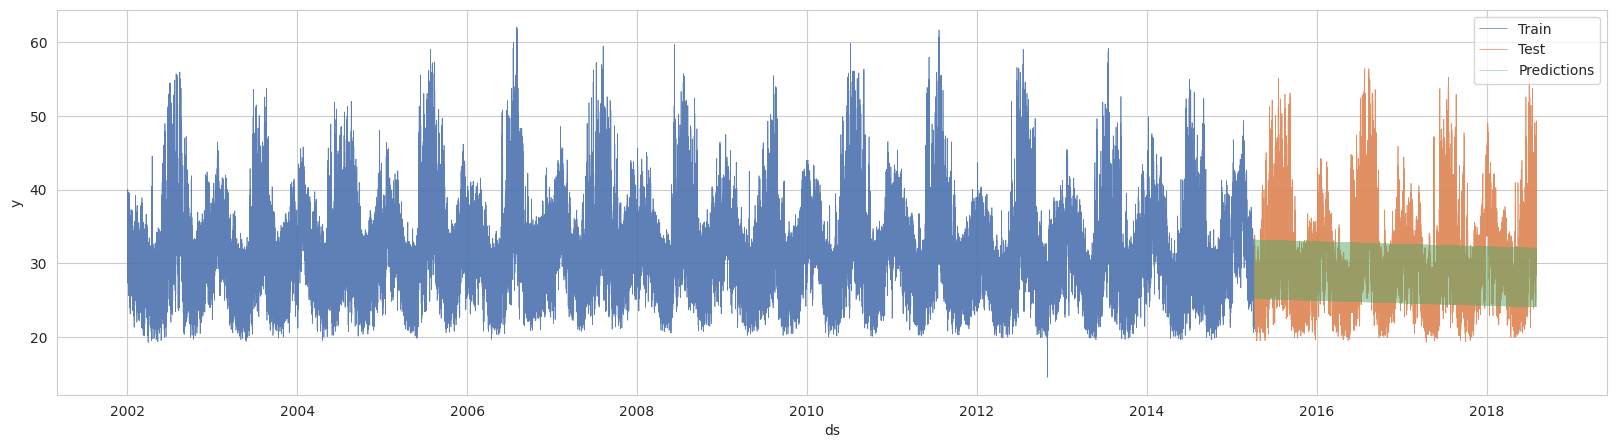

🏃 View run ETS - additive at: https://dagshub.com/joseadolfo1/dsrptrabajofinalmle2.mlflow/#/experiments/0/runs/faef323637ba47b4a46d8fa95dd5d310
🧪 View experiment at: https://dagshub.com/joseadolfo1/dsrptrabajofinalmle2.mlflow/#/experiments/0


/home/joe/Documents/DsrpTrabajoFinalMLE2/dsrptrabajofinalmle2/.venv/lib/python3.10/site-packages/mlflow/store/tracking/rest_store.py:182: DeprecationWarning: label() is deprecated. Use is_required() or is_repeated() instead.
  req_body = message_to_json(


In [10]:
mlflow.autolog()
with mlflow.start_run(run_name="ETS - additive") as run:

    train = train_df[["ds","y"]]
    test = test_df[["ds","y"]]
    
    model = ExponentialSmoothing(train['y'], trend='additive', seasonal='additive', seasonal_periods=24,initialization_method="estimated").fit()
    
    predictions = model.forecast(len(test['y']))
    
    mae = mean_absolute_error(test['y'], predictions)
    mape = mean_absolute_percentage_error(test['y'], predictions)
    mse = mean_squared_error(test['y'], predictions)
    rmse = np.sqrt(mse)

    mlflow.log_metric("MAE", mae)
    mlflow.log_metric("MAPE", mape)
    mlflow.log_metric("MSE", mse)
    mlflow.log_metric("RMSE", rmse)

    sns.set_style("whitegrid")
    sns.set_palette("deep") 
    plt.figure(figsize=(20, 5))    
    
    sns.lineplot(x='ds', y='y', data=train, label='Train', linewidth=0.5, alpha=0.90)
    sns.lineplot(x='ds', y='y', data=test, label='Test', linewidth=0.5, alpha=0.90)
    sns.lineplot(x=test['ds'], y=predictions, label='Predictions', linewidth=0.5, alpha=0.50)
    
    mlflow.log_figure(plt.gcf(), "ETS_additive.png")

    plt.show()


# XGBOOST

2025/08/24 18:45:03 WARNING mlflow.utils.autologging_utils: MLflow sklearn autologging is known to be compatible with 0.24.1 <= scikit-learn <= 1.6.1, but the installed version is 1.7.1. If you encounter errors during autologging, try upgrading / downgrading scikit-learn to a compatible version, or try upgrading MLflow.
2025/08/24 18:45:03 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/08/24 18:45:03 WARNING mlflow.utils.autologging_utils: MLflow statsmodels autologging is known to be compatible with 0.12.2 <= statsmodels <= 0.14.4, but the installed version is 0.14.5. If you encounter errors during autologging, try upgrading / downgrading statsmodels to a compatible version, or try upgrading MLflow.
2025/08/24 18:45:03 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2025/08/24 18:45:03 WARNING mlflow.utils.autologging_utils: MLflow xgboost autologging is known to be compatible with 1.4.2 <= xgboost <= 3.0.0, but the insta

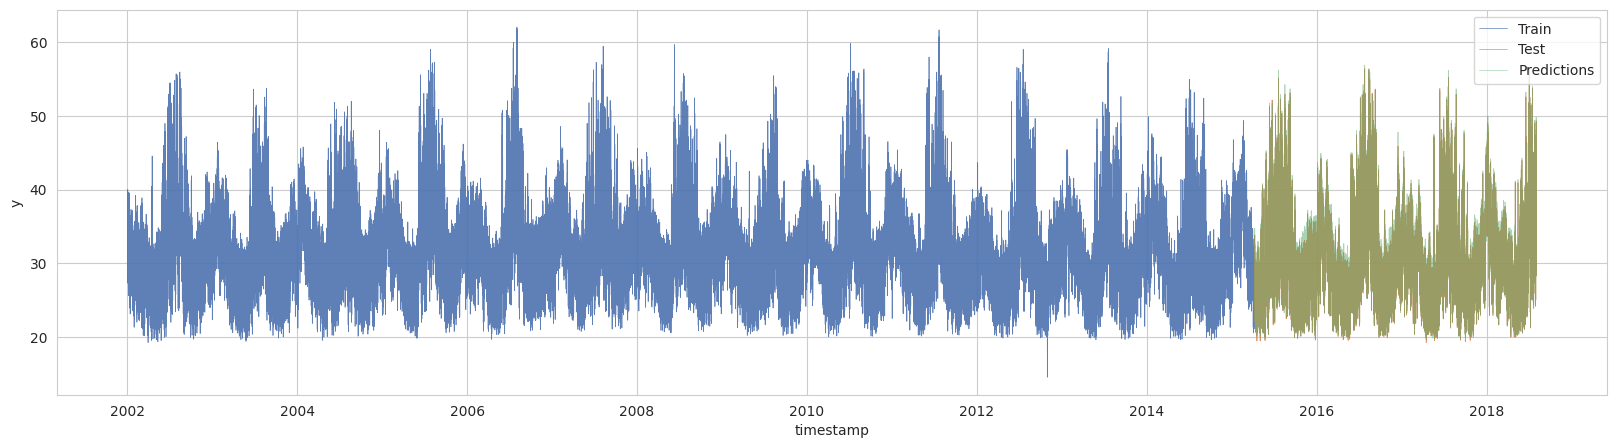

🏃 View run XGBOOST at: https://dagshub.com/joseadolfo1/dsrptrabajofinalmle2.mlflow/#/experiments/0/runs/d03e1d4ed00c4870a48e99e00ab16818
🧪 View experiment at: https://dagshub.com/joseadolfo1/dsrptrabajofinalmle2.mlflow/#/experiments/0


/home/joe/Documents/DsrpTrabajoFinalMLE2/dsrptrabajofinalmle2/.venv/lib/python3.10/site-packages/mlflow/store/tracking/rest_store.py:182: DeprecationWarning: label() is deprecated. Use is_required() or is_repeated() instead.
  req_body = message_to_json(


In [11]:
mlflow.autolog()
with mlflow.start_run(run_name="XGBOOST") as run:

    xgboost_df = hist[["ds", "y"]].copy()
    
    xgboost_df["LAG1"] = xgboost_df['y'].shift(1)
    xgboost_df["LAG2"] = xgboost_df['y'].shift(2)
    xgboost_df["LAG3"] = xgboost_df['y'].shift(3)
    xgboost_df["LAG4"] = xgboost_df['y'].shift(4)
    xgboost_df["ds"] = pd.to_datetime(xgboost_df['ds'])
    
    xgboost_df = xgboost_df.sort_values('ds').set_index('ds', drop=False)
    xgboost_df.index.name = "timestamp" 

    
    x, y = xgboost_df.drop(['y','ds'], axis=1), xgboost_df['y']
    x_train, x_test, y_train, y_test = train_test_split(x, y, shuffle=False, test_size=0.2, random_state=42)
    
    
    xgb = XGBRegressor().fit(x_train, y_train)                          
    y_pred = xgb.predict(x_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    mlflow.log_metric("MAE", mae)
    mlflow.log_metric("MAPE", mape)
    mlflow.log_metric("MSE", mse)
    mlflow.log_metric("RMSE", rmse)

    sns.set_style("whitegrid")
    sns.set_palette("deep") 
    plt.figure(figsize=(20, 5))    
    
    sns.lineplot(x=x_train.index, y=y_train,  label='Train', linewidth=0.5, alpha=0.90)
    sns.lineplot(x=x_test.index, y=y_test, label='Test', linewidth=0.5, alpha=0.90)
    sns.lineplot(x=x_test.index, y=y_pred, label='Predictions', linewidth=0.5, alpha=0.50)

    mlflow.log_figure(plt.gcf(), "XGBOOST.png")
    plt.show()